In [1]:
import xarray as xr
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
#import xrft
import matplotlib.pyplot as plt
#import pandas as pd
from tqdm import tqdm
import os
import glob
from pathlib import Path
from typing import Union, List
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch.nn.functional as F
import cartopy.crs as ccrs
import pickle

In [2]:
from src.utils import load_ssf_acoustic_variables, load_sound_speed_fields
from src.data import TrainingItem, AutoEncoderDatamodule, BaseDatamodule
from src.acoustic_predictor import ConvBlock, AcousticPredictor
from src.autoencoder import AutoEncoder

In [3]:

sound_speed_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ecs_path = "/DATASET/eNATL/eNATL60_BLB002_cutoff_freq_regrid_0_1000m.nc"

In [4]:
ae_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_4_sigmoid_lr_0.001/2024-04-15_17-37"
model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[0]
arch_shape = '_'.join(ae_path.split('/')[-1].split('_')[:2])

model_ap_path= "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/"
model_ap_path = glob.glob(f"{model_ap_path}/**/*.ckpt",recursive=True)[0]
acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path, input_depth= 107)


print('ae model: ', model_ae_path)

print('ap model: ', model_ap_path)

ae model:  /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_4_sigmoid_lr_0.001/2024-04-15_17-37/checkpoints/val_loss=0.18-epoch=01.ckpt
ap model:  /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/2024-04-08_16-27/checkpoints/val_loss=0.04-epoch=03.ckpt


In [5]:
y_min_axs = -20
y_max_axs = 1020
x_min_axs = 1450
x_max_axs = 1550

In [6]:
plt.style.use('ggplot')

In [7]:
gpu = None

if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [8]:
load_data = False

# Functions

## load datamodule

In [9]:

def init_ae(model_ae_path:str,  
            sound_speed_path:str,
            ecs_path:Union[str, None] = None,
            gpu:Union[int,None]= None,
            verbose:float = True):
    
    
    if torch.cuda.is_available() and gpu is not None:
    ##This may not be necessary outside the notebook
        dev = f"cuda:{gpu}"
    else:
        dev = "cpu"

    device = torch.device(dev)

    if verbose:
        print("Selected device:", device)


    if model_ae_path[-5:] == ".ckpt":
        pass

    elif os.path.isdir(model_ae_path):
        model_ae_path = glob.glob(os.path.join(model_ae_path, "**/*.ckpt"), recursive=True)[0]

    else:
        raise ValueError("model_ae_path should leads towards a chekpoint file (.ckpt) or toward a directory containing one checkpoint file. Research in sub_directories is allowed but only the chekpoint file found first is retrieved")

    ap_indicator, arch_shape =  model_ae_path.split("/")[-4:-2]

    
    if verbose:
        print("Selected AutoEncoder model:", model_ae_path)

    if ap_indicator == "AE_with_AP" : 

        if ecs_path is None:
            raise ValueError("For models using acoustic predictor, ecs_path should be defined")
        
        
        input_da = load_ssf_acoustic_variables(sound_speed_path, ecs_path) 
        
        #* By default the first chekpoint is selected
        
    else:
        model_ap_path = None
        input_da = load_sound_speed_fields(sound_speed_path)  
        
    if verbose:
        print("Selected Accoustic Predictor model:", str(model_ap_path)) 
        print("Loading celerity data")
    
    return input_da, ap_indicator, arch_shape, device

In [10]:
def test_dataloader_normalization(dataloader):
    
    for batch_number, batch in enumerate(dataloader):
        
        errors = []
        if batch.input.min() < -1:
            errors.append("Minimum value of input is less than -1.")
        if batch.input.max() > 1:
            errors.append("Maximum value of input is greater than 1.")
        if batch.tgt[:,0,:,:].min() < -1:
            errors.append("Minimum value of target ECS is less than -1.")
        if batch.tgt[:,0,:,:].max() > 1:
            errors.append("Maximum value of target ECS is greater than 1.")
        if abs(batch.input.max() - batch.input.min()) > 2:
            errors.append("Absolute difference between input max and min is greater than 2.")
        if abs(batch.tgt[:,0,:,:].max() - batch.tgt[:,0,:,:].min()) > 2:
            errors.append("Absolute difference between target ECS max and min is greater than 2.")
        
        if errors:
            error_message = "Validation failed for batch {}: {}".format(batch_number, "\n ".join(errors))
            raise ValueError(error_message)

In [11]:
def load_datamodule(input_da: tuple,
                    x_min: Union[float, None] = None,
                    x_max: Union[float, None] = None,
                    phases: Union[str, List[str]] = ["train", "test"],
                    domains: dict = dict(
                        train = dict(time = slice(0, 254, None)),
                        val = dict(time = slice(254, 331, None)),
                        test = dict(time = slice(331, 365, None))
                        ),
                    verbose:float = True
                    ):
    
    
    if isinstance(phases, str):
        phases = list(phases)
    
    elif isinstance(phases, list):
        pass
    
    else: 
        raise ValueError("Argument phases should be a string or a list of strings")
    
    dm_dict = dict()
    
    dl_kw = dict(batch_size = None,
                 num_workers = 1)
    
    fit_setup = False
    
    dm = BaseDatamodule(input_da, dl_kw = dl_kw, x_min=x_min, x_max =x_max)
    
    
    for phase in tqdm(phases, unit = "phase", desc = "Genereting Dataloaders on selected splits"):
        
        if verbose:
            print("phase:", phase)


        
        # print(input_da[0].celerity.data.min(),input_da[0].celerity.data.max())
        # #coords = input_da.isel(domains[phase]).coords


        if phase == 'train':

            if not fit_setup:
                if verbose:
                    print("\t Train setup")
                dm.setup(stage = 'fit')
                fit_setup = True
            
            if verbose:
                print("\tGenerating dataloader")
                
            dm.dl_kw['batch_size'] = len(dm.train_ds.volume.coords['time'])
            dataloader = dm.train_dataloader()
        
        
        elif phase == "val":

            
            if not fit_setup:
                if verbose:
                    print("\t Validation setup")
                dm.setup(stage = 'fit')
                fit_setup = True
            
            if verbose:
                print("\tGenerating dataloader")
            dm.dl_kw['batch_size'] = len(dm.val_ds.volume.coords['time'])
            dataloader = dm.val_dataloader()
        
        
        elif phase == 'test':  
            if verbose:
                print("\t Test setup")
            dm.setup(stage = 'test')
            
            if verbose:
                print("\tGenerating dataloader")
            
            dm.dl_kw['batch_size'] = len(dm.test_ds.volume.coords['time'])
            dataloader = dm.test_dataloader()

        else: 
            raise ValueError("phase in phases should be train, val or test")
        
        if len(dataloader) != 1:
                raise ValueError("Dataloader should only contain 1 batch. This should never be seen for debugging purpose only")

        if verbose:
            print("Testing dataloader normalization")
        test_dataloader_normalization(dataloader)
            
        


            

        batch = next(iter(dataloader))

        dm_dict[phase] = batch
        

        
    return dm_dict



## ECS

In [12]:
def reduce_profile(z_w, sos_w):
    """
    Reduce a profile by finding min-max singular points (linear reduction)

    Parameters
    ----------
    z_w : Float array
        depth values (in m > 0).
    sos_w : Float array
        sound velocities along z_w (in m/s).

    Comment
    -------
    Assumption is made by the profile is regular (starts at surface and stop at
    bottom). None or nan value need to be dealt with before the reduction

    Returns
    -------
    z_w_red : Float array
        Singular point depth values.
    sos_w_red : Float array
        Singular point sound speed values.

    """
    # compute the sign of consecutive points differences, then, search where
    # change occurs by differencing again and finding where results equal 2.
    ind = np.where(abs(np.diff(np.sign(np.diff(sos_w)))) == 2)
    # compensation for loosing one in index dimension due to differencation
    ind += np.ones((len(ind)))

    sos_w_red = sos_w[[int(i) for i in ind[0]]]
    z_w_red = z_w[[int(i) for i in ind[0]]]

    # insert surface point and bottom point
    sos_w_red = np.insert(sos_w_red, 0, sos_w[0])
    z_w_red = np.insert(z_w_red, 0, 0)
    sos_w_red = np.insert(sos_w_red, len(sos_w_red), sos_w[-1])
    z_w_red = np.insert(z_w_red, len(z_w_red), z_w[-1])

    return z_w_red, sos_w_red

# Load Data

In [13]:
if not load_data:
    ss_ds, acc_ds = load_ssf_acoustic_variables(sound_speed_path,ecs_path)

## Time split

In [14]:
# with open(pickle_ae_path, 'rb') as file:
#     time_idx_split = pickle.load(file)
    
# time_idx =  np.concatenate(list(time_idx_split.values()))



In [15]:
# if not load_data:
#     ss_ds = ss_ds.reindex(time=time_idx)
#     acc_ds = acc_ds.reindex(time=time_idx)


# acc_ds_test = acc_ds.sel(time=time_idx_split['test'])
# ss_ds_test = ss_ds.sel(time=time_idx_split['test'])
# coords_test = ss_ds_test.coords

This selection is rather long, should not be rerun every time

## Manage NaN

In [16]:
# print(ss_ds.dropna(dim='lat').dims)
# print(ss_ds.dropna(dim='lon').dims)
# print(ss_ds.dropna(dim='time').dims)
# print(ss_ds.dropna(dim='z').dims)


In [17]:
if not load_data:

    ss_ds = ss_ds.dropna(dim='lat')
    acc_ds = acc_ds.sel(lat = ss_ds.lat)


In [18]:
if not load_data:
    input_da = (ss_ds,acc_ds)

    del ss_ds
    del acc_ds

In [19]:
if not load_data:
    with open("/DATASET/envs/o23gauvr/tmp/input_da_no_nan.pkl", "wb") as file:
        pickle.dump(input_da, file)

# PCA

# Load datamodule

In [20]:


x_min = 1459.0439165829073
x_max = 1545.8698054910844
verbose = True
gpu = None

domains = dict(
    train = dict(time = slice(0, 254, None)),
    val = dict(time = slice(254, 331, None)),
    test = dict(time = slice(331, 365, None))
    )


In [21]:
if not load_data:
    dm = load_datamodule(input_da,
                        x_min,
                        x_max
                        )
    
    with open("/DATASET/envs/o23gauvr/tmp/datamodule_test_train_no_nan.pkl", "wb") as file:
        pickle.dump(dm, file)
        
else:
    with open("/DATASET/envs/o23gauvr/tmp/datamodule_test_train_no_nan.pkl", "rb") as file:
        dm = pickle.load(file)

Genereting Dataloaders on selected splits:   0%|          | 0/2 [00:00<?, ?phase/s]

phase: train
	 Train setup


In [ ]:
x_train, y_train = dm['train']
input_train_shape = x_train.shape


x_test, y_train = dm['test']
input_test_shape = x_test.shape

print("\n normalization values")
print("x test min", x_test.min())
print("x test max",x_test.max())






 normalization values
x test min tensor(0.1998)
x test max tensor(0.9782)


In [ ]:
ae_path_dict = {
"4_4_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_4_relu_lr_0.001",
"16_60_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/16_60_relu_lr_0.001",
"pca_4_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/pca_4_relu_lr_0.001",
"4_15_test_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_15_test_relu_lr_0.001",
"4_4_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/4_4_relu_lr_0.001",
"16_60_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/16_60_relu_lr_0.001",
"pca_4_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/pca_4_relu_lr_0.001",
"4_15_test_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/4_15_test_relu_lr_0.001"  
}

output_ae_test_dict = {}

time_idx = []

ae_path = list(ae_path_dict.values())[0]
model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[0]


for arch_shape,ae_path in ae_path_dict.items():
    arch_shape_struct = '_'.join(arch_shape.split('_')[:2])
    print(f"\n architecture: {arch_shape}")
    model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
    pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[0]
    
    model_ae = AutoEncoder.load_from_checkpoint(model_ae_path,x_min = x_min, x_max = x_max, acoustic_predictor= acoustic_predictor, arch_shape = arch_shape_struct).to(device)
    output_ae_test = model_ae(x_test.to(device)).cpu().detach().numpy()* (x_max - x_min)+ x_min
    
    output_ae_test_dict[arch_shape] = output_ae_test
    
    
    print("min value", model_ae(x_test.to(device)).cpu().detach().numpy().min())
    print("max value",model_ae(x_test.to(device)).cpu().detach().numpy().max())


 architecture: 4_4_without_AP
min value 0.48705393
max value 0.76993555

 architecture: 16_60_without_AP
min value 0.012356237
max value 0.9669349

 architecture: pca_4_without_AP
min value 3.708758e-05
max value 0.73630667

 architecture: 4_15_test_without_AP
min value 0.02928077
max value 0.92045856

 architecture: 4_4_with_AP
min value 0.4798249
max value 0.770031

 architecture: 16_60_with_AP
min value 3.6484238e-07
max value 0.95057786

 architecture: pca_4_with_AP
min value 0.24060366
max value 0.7417967

 architecture: 4_15_test_with_AP
min value 0.5202904
max value 0.7301039


In [ ]:
###* test
for arch_shape,ae_path in ae_path_dict.items():
    arch_shape_struct = '_'.join(arch_shape.split('_')[:-2])
    print(f"\n architecture: {arch_shape}")
    model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
    
    with open(pickle_ae_path, 'rb') as file:
        time_idx_split = pickle.load(file)
    time_idx.append(time_idx_split['test'])
    print(time_idx_split['test'][:5],'...',time_idx_split['test'][-5:])


 architecture: 4_4_without_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: 16_60_without_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: pca_4_without_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: 4_15_test_without_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: 4_4_with_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: 16_60_with_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: pca_4_with_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]

 architecture: 4_15_test_with_AP
[136, 291, 317, 107, 104] ... [344, 304, 324, 199, 335]


In [ ]:
with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/profiles_of_interest_idx.pkl", "rb") as file:
    profile_idx_dict = pickle.load(file)

profile_idx_dict

{'min_std': tensor([[334, 100,  83],
         [334, 100,  82],
         [334, 100,  84],
         [334, 101,  83],
         [335, 100,  85],
         [334,  99,  83],
         [335,  99,  85],
         [335, 100,  86],
         [334, 101,  84],
         [335,  99,  84],
         [334,  99,  82],
         [335,  99,  86],
         [334, 101,  82],
         [335, 100,  84],
         [334,  99,  84],
         [334, 100,  81],
         [335, 100,  87],
         [335,  99,  83],
         [334, 100,  85],
         [334,  99,  81],
         [333, 101,  81],
         [333, 102,  80],
         [333, 102,  81],
         [333, 101,  80],
         [334, 101,  85],
         [334, 101,  81],
         [335, 100,  83],
         [335,  99,  87],
         [333, 101,  82],
         [334,  98,  83]]),
 'max_std': tensor([[ 96, 169,   1],
         [ 96, 169,   2],
         [ 96, 169,   0],
         [ 96, 168,   0],
         [ 89, 132,  13],
         [ 89, 134,  12],
         [ 89, 133,  12],
         [ 89,

In [ ]:
ss_ds, acc_ds = load_ssf_acoustic_variables(sound_speed_path,ecs_path)
acc_ds_test = acc_ds.isel(time=time_idx_split['test'])
acc_ds_test

<xarray.Dataset>
Dimensions:      (time: 36, lat: 240, lon: 240)
Coordinates:
  * lat          (lat) float64 32.0 32.05 32.1 32.15 ... 43.8 43.85 43.9 43.95
  * lon          (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * time         (time) datetime64[ns] 2009-11-14T12:00:00 ... 2010-06-01T12:...
Data variables:
    ecs          (time, lat, lon) float64 80.84 80.84 86.15 ... 148.3 148.3
    cutoff_freq  (time, lat, lon) float64 282.0 303.0 300.0 ... 102.0 91.0 98.0

In [ ]:
x_test.shape

torch.Size([36, 107, 174, 240])

In [ ]:
profile_idx_dict['random_1000']

array([[102,   2, 225],
       [348, 160, 216],
       [270, 133,  49],
       ...,
       [138,  19,  44],
       [355,  42, 160],
       [332, 125, 144]])

In [ ]:
acc_ds_test.isel(time=profile_idx_dict['random_1000'][:,0], lat = profile_idx_dict['random_1000'][:,1], lon = profile_idx_dict['random_1000'][:,2]).celerity

IndexError: index 102 is out of bounds for axis 0 with size 36

In [ ]:
ecs_from_ae_rmse_dict = {}

for arch_shape,output_ae_test in output_ae_test_dict.items():
    ecs_list = []
    ecs_truth_list = acc_ds_test.isel(time=profile_idx_dict['random_1000'][:,0], lat = profile_idx_dict['random_1000'][:,1], lon = profile_idx_dict['random_1000'][:,2]).celerity

    for i in range(len(profile_idx_dict['random_1000'])):
        ecs_list.append(reduce_profile(coords_test['z'].values, output_ae_test[profile_idx_dict['random_1000'][i][0],:,profile_idx_dict['random_1000'][i][1],profile_idx_dict['random_1000'][i][2]])[0][1])
        
    ecs_from_ae_rmse_dict[arch_shape] = np.sqrt(np.mean((ecs_truth_list - np.array(ecs_list))**2))
    

In [ ]:
print(model_ae(x_test.to(device)).cpu().detach().numpy().min())
print(model_ae(x_test.to(device)).cpu().detach().numpy().max())

0.11679165
0.75109816


## PCA over depth

In [ ]:

input_train_depth_feature = x_train.reshape(-1,input_train_shape[-1]).to('cpu')
input_test_depth_feature = x_test.reshape(-1,input_test_shape[-1]).to('cpu')


### Get RMSE per components

In [ ]:
rmse_dict = {}
n_components_list = [i for i in range(1, 16)] + [30, 50,100, 107]

for n_components in n_components_list:
    
    pca = PCA(n_components = n_components)
    pca.fit(input_train_depth_feature)
    output_test_decoded_pca = pca.inverse_transform(pca.transform(input_test_depth_feature)).reshape(input_test_shape)
    #output_test_decoded_pca = output_test_decoded_pca*(x_max - x_min)+ x_min

    ecs_list = []
    ecs_truth_list = []
    for i in range(len(profile_idx_dict['random_1000'])):
        ecs_truth_list.append(acc_ds_test.isel(time=profile_idx_dict['random_1000'][i][0], lat = profile_idx_dict['random_1000'][i][1], lon = profile_idx_dict['random_1000'][i][2]).celerity)
        ecs_list.append(reduce_profile(coords_test['z'].values, output_test_decoded_pca[profile_idx_dict['random_1000'][i][0],:,profile_idx_dict['random_1000'][i][1],profile_idx_dict['random_1000'][i][2]])[0][1])
    

    rmse_dict[n_components]=np.sqrt(np.mean((np.array(ecs_truth_list) - np.array(ecs_list))**2))

NameError: name 'input_train_depth_feature' is not defined

In [ ]:
rmse_dict

{1: 328.2582523983826,
 2: 284.9231098151561,
 3: 266.2688212599639,
 4: 262.77607741890233,
 5: 250.85868172485786,
 6: 241.0590766255249,
 7: 242.41490117818225,
 8: 245.98930097061765,
 9: 235.91242896665855,
 10: 230.48186540872598,
 11: 228.45243904843673,
 12: 234.82970211117512,
 13: 234.86660833965104,
 14: 224.90342180021756,
 15: 223.88771490708086,
 30: 224.4876955927679,
 50: 220.8623769114466,
 100: 219.07044875617513,
 107: 226.35298188582223}

In [ ]:
# with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/ecs_pca_rmse_per_components.pkl", "wb") as file:
#     pickle.dump(rmse_dict, file)

Text(0.5, 0.95, 'Max std in first 150m celerity profiles')

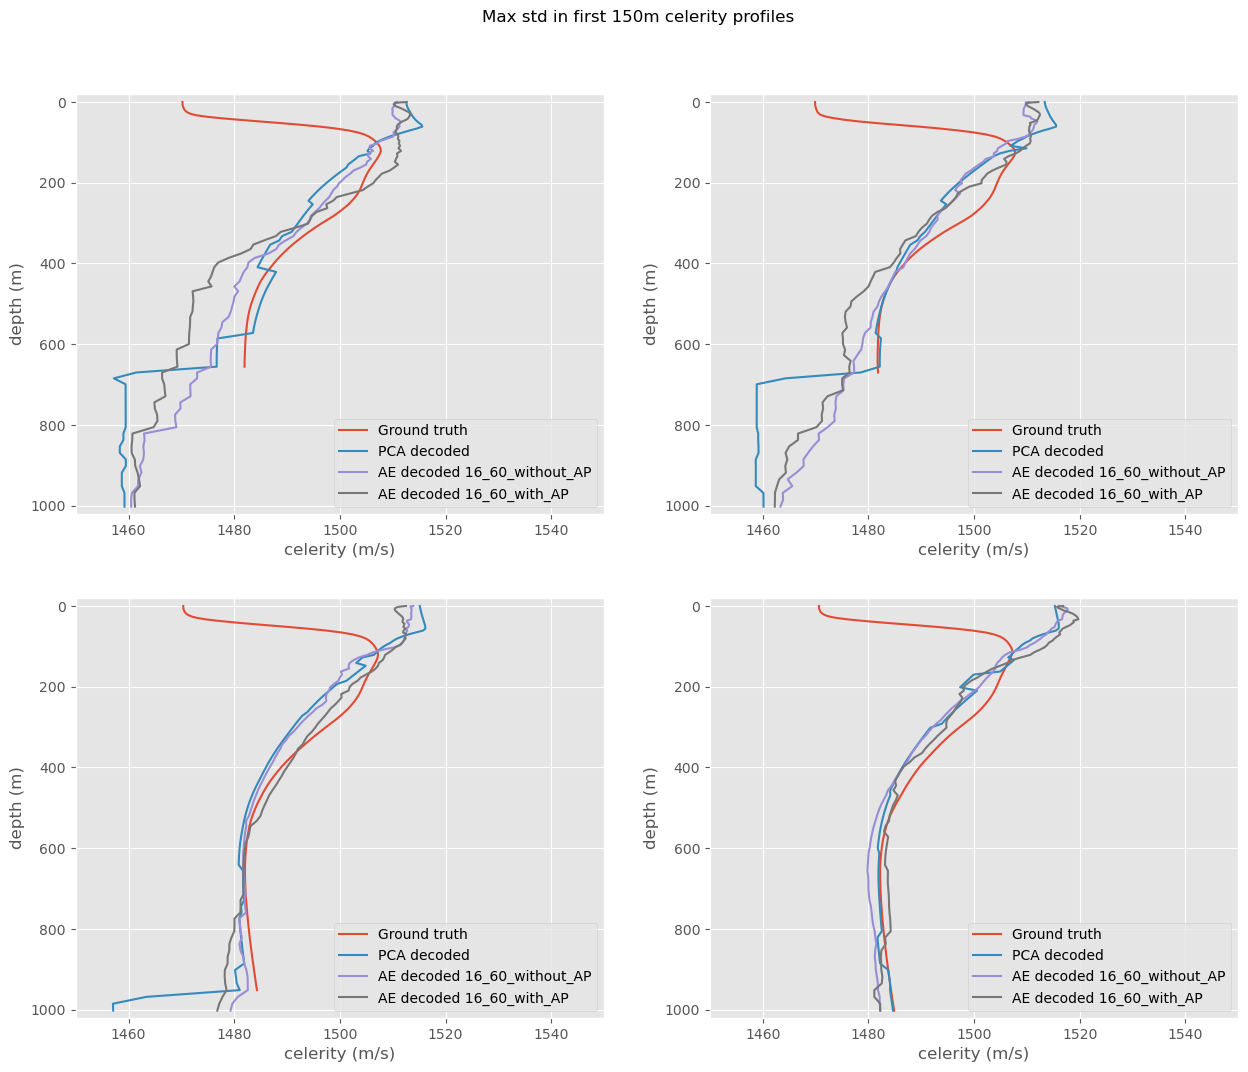

In [ ]:
fig,axs = plt.subplots(2,2, figsize = (15,12))
for i,ax in enumerate(axs.flatten()):
    t,lat,lon = min_ss_std_idx[i]
    ax.plot(ss_ds_test.isel(time = profile_idx_dict['max_std_150'][i][0], lat = profile_idx_dict['max_std_150'][i][1], lon = profile_idx_dict['max_std_150'][i][2]),coords_test['z'].values, label = 'Ground truth')
    ax.plot(output_test_decoded_pca[profile_idx_dict['max_std_150'][i][0],:,profile_idx_dict['max_std_150'][i][1],profile_idx_dict['max_std_150'][i][2]],coords_test['z'].values, label = 'PCA decoded')
    for arch_shape,output_ae_test in output_ae_test_dict.items():
        if '_'.join(arch_shape.split('_')[:-2]) in ['16_60']:
            ax.plot(output_ae_test[profile_idx_dict['max_std_150'][i][0],:,profile_idx_dict['max_std_150'][i][1],profile_idx_dict['max_std_150'][i][2]],coords_test['z'].values, label = f"AE decoded {arch_shape}")
    ax.set_ylim(y_min_axs, y_max_axs)  # Set y-axis limits
    ax.set_xlim(x_min_axs, x_max_axs)  # Set x-axis limits
    ax.invert_yaxis()
    ax.set_xlabel('celerity (m/s)')
    ax.set_ylabel('depth (m)')
    ax.legend()
title = "Max std in first 150m celerity profiles"
fig.suptitle(title, y = 0.95)

In [ ]:
ss_ds_test.isel(time = profile_idx_dict['max_std_150'][0][0], lat = profile_idx_dict['max_std_150'][0][1], lon = profile_idx_dict['max_std_150'][0][2])

<xarray.DataArray 'celerity' (z: 107)>
array([1470.190047, 1470.199971, 1470.213068, 1470.201795, 1470.201155,
       1470.213494, 1470.242238, 1470.290441, 1470.349566, 1470.422291,
       1470.520307, 1470.664455, 1470.883797, 1471.218594, 1471.786278,
       1472.82957 , 1474.681236, 1477.393871, 1480.734454, 1484.532748,
       1488.542053, 1492.487036, 1496.056682, 1499.073936, 1501.511569,
       1503.342655, 1504.60288 , 1505.477609, 1506.131947, 1506.66    ,
       1507.100013, 1507.451916, 1507.674838, 1507.721158, 1507.583114,
       1507.322082, 1506.995109, 1506.628977, 1506.246762, 1505.851457,
       1505.479747, 1505.135343, 1504.837702, 1504.561962, 1504.293097,
       1504.040295, 1503.753502, 1503.355589, 1502.888711, 1502.283261,
       1501.611107, 1500.781156, 1499.858864, 1498.855883, 1497.63549 ,
       1496.419327, 1495.233267, 1494.114038, 1493.043959, 1492.012204,
       1491.006786, 1490.071902, 1489.203889, 1488.373224, 1487.600621,
       1486.90583 , 1486.185327, 1485.546226, 1484.972383, 1484.512278,
       1484.10526 , 1483.723352, 1483.375082, 1483.054576, 1482.806581,
       1482.607879, 1482.444366, 1482.326522, 1482.209254, 1482.132271,
       1482.073651, 1482.023853, 1481.989494, 1481.948074, 1481.946654,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan])
Coordinates:
    lon      float64 -63.85
    lat      float64 42.7
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
    time     datetime64[ns] 2010-04-20T12:00:00

In [ ]:
output_ae_test_dict['16_60_without_AP'][profile_idx_dict['max_std_150'][0][0],:,profile_idx_dict['max_std_150'][0][1],profile_idx_dict['max_std_150'][0][2]]

array([1510.804 , 1510.3997, 1510.418 , 1510.3707, 1510.4075, 1510.3679,
       1510.3319, 1510.2156, 1510.0929, 1509.9624, 1509.8912, 1509.9357,
       1509.968 , 1509.9382, 1509.9294, 1509.9971, 1510.2645, 1510.5009,
       1510.9895, 1511.4338, 1511.3861, 1511.2148, 1511.2659, 1510.997 ,
       1510.5663, 1510.1406, 1510.2456, 1510.0358, 1508.8198, 1507.5618,
       1507.0367, 1505.6544, 1505.6082, 1506.2682, 1505.3279, 1505.3148,
       1505.8601, 1505.1432, 1504.9512, 1503.8743, 1502.5546, 1501.9464,
       1501.1089, 1500.483 , 1499.8198, 1499.4116, 1498.7535, 1498.3519,
       1497.964 , 1497.2747, 1496.6156, 1496.0908, 1495.2778, 1494.4878,
       1494.2911, 1493.6997, 1492.6863, 1491.759 , 1491.1906, 1489.7443,
       1488.4633, 1487.9418, 1486.4761, 1483.823 , 1482.6685, 1482.4839,
       1481.7767, 1481.3784, 1480.9886, 1479.9944, 1480.7292, 1480.0521,
       1479.8706, 1479.5947, 1479.3241, 1478.9115, 1477.7394, 1477.5566,
       1476.9843, 1476.8481, 1476.729 , 1475.6229, 

In [ ]:
ecs_from_ae_rmse_dict

{'4_4_without_AP': 142.92368500890598,
 '16_60_without_AP': 154.66496492834483,
 'pca_4_without_AP': 143.87418207892804,
 '4_15_test_without_AP': 142.50497535824002,
 '4_4_with_AP': 141.08240493543775,
 '16_60_with_AP': 161.642926710192,
 'pca_4_with_AP': 143.49159559632201,
 '4_15_test_with_AP': 141.0816116050426}

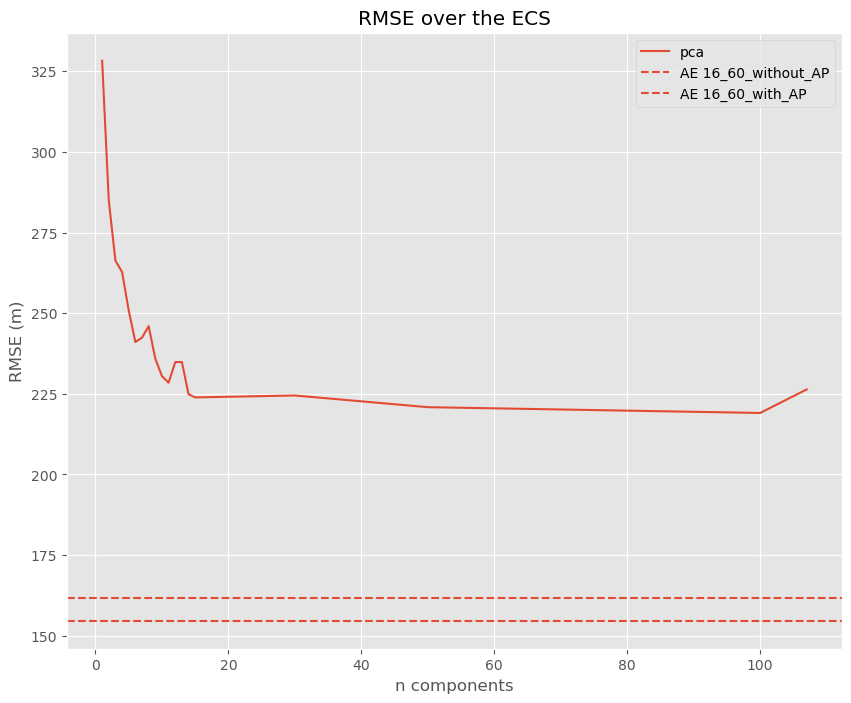

In [ ]:
plt.figure(figsize=(10,8))

n_compo = list(rmse_dict.keys())
rmse_pca = list(rmse_dict.values())

# Plot the data
plt.plot(n_compo, rmse_pca,label='pca')

#Add a horizontal line at y=3
for arch_shape,ae_rmse in ecs_from_ae_rmse_dict.items():
    if '_'.join(arch_shape.split('_')[:-2]) in ['16_60']:
        plt.axhline(y=ae_rmse, linestyle='--', label=f'AE {arch_shape}')
# plt.axhline(y=ecs_from_ae_rmse_dict['16_60_without_AP'],c = 'r' ,linestyle='--', label=f'AE 16_60_without_AP')
# plt.axhline(y=ecs_from_ae_rmse_dict['16_60_with_AP'], c = 'g', linestyle='--', label=f'AE 16_60_with_AP')
# Add labels and title
plt.xlabel('n components')
plt.ylabel('RMSE (m)')
plt.title('RMSE over the ECS')

# Add legend
plt.legend()

# Show plot
plt.show()

Text(0.5, 0.95, 'Random celerity profiles')

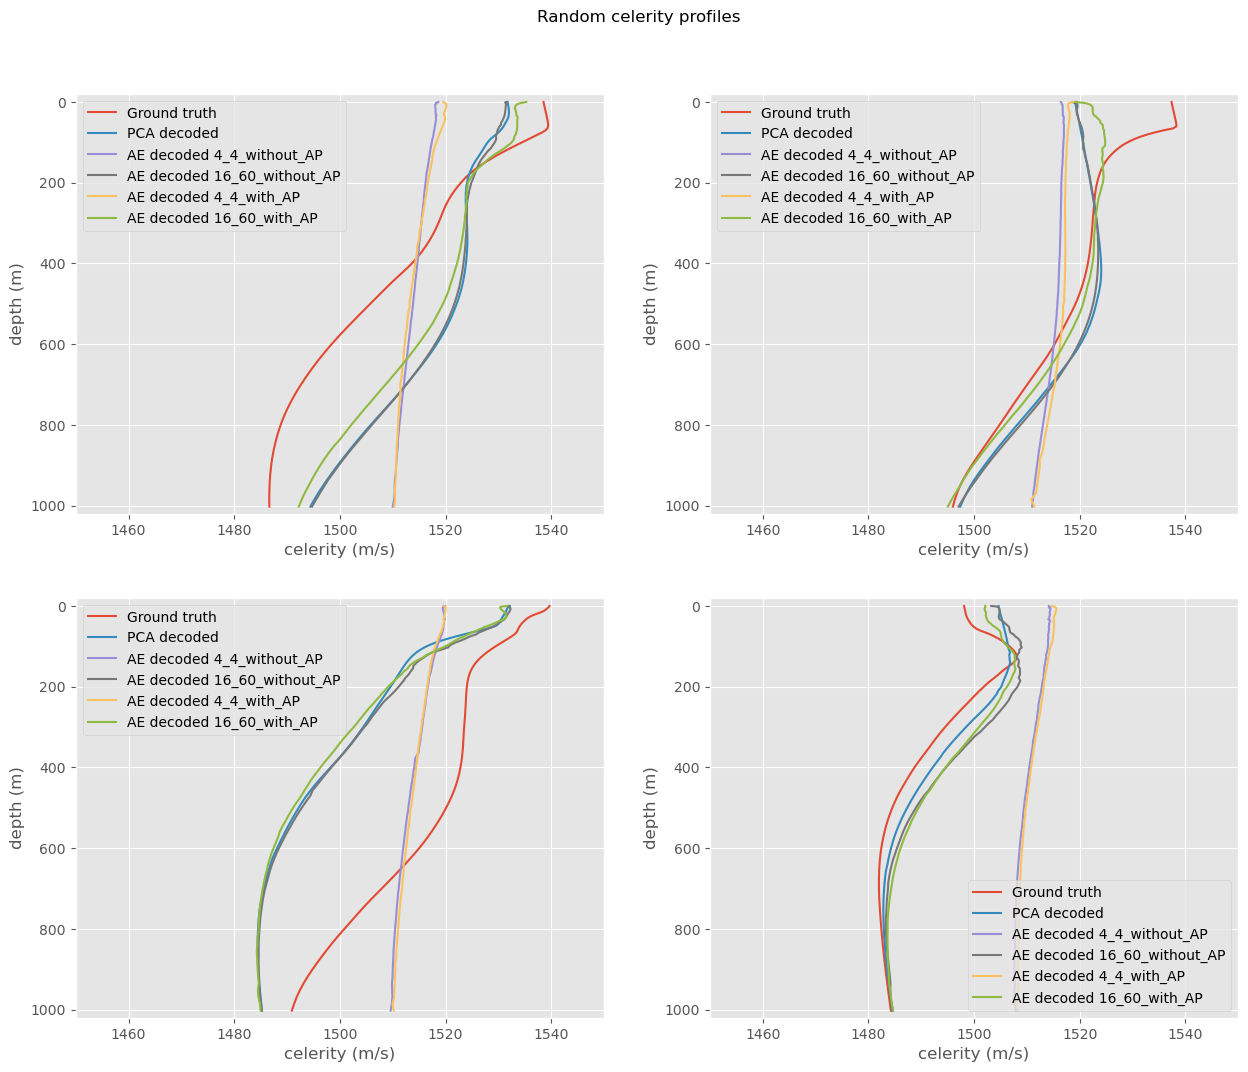

In [ ]:
fig,axs = plt.subplots(2,2, figsize = (15,12))
for i,ax in enumerate(axs.flatten()):
    t,lat,lon = profile_idx_dict['min_std'][i]
    ax.plot(ss_ds_test.isel(time = profile_idx_dict['random_1000'][i][0], lat = profile_idx_dict['random_1000'][i][1], lon = profile_idx_dict['random_1000'][i][2]),coords_test['z'].values, label = 'Ground truth')
    ax.plot(output_test_decoded_pca[profile_idx_dict['random_1000'][i][0],:,profile_idx_dict['random_1000'][i][1],profile_idx_dict['random_1000'][i][2]],coords_test['z'].values, label = 'PCA decoded')
    for arch_shape,output_ae_test in output_ae_test_dict.items():
        if '_'.join(arch_shape.split('_')[:-2]) in ['16_60','4_4']:
            ax.plot(output_ae_test[profile_idx_dict['random_1000'][i][0],:,profile_idx_dict['random_1000'][i][1],profile_idx_dict['random_1000'][i][2]],coords_test['z'].values, label = f"AE decoded {arch_shape}")
    ax.set_ylim(y_min_axs, y_max_axs)  # Set y-axis limits
    ax.set_xlim(x_min_axs, x_max_axs)  # Set x-axis limits
    ax.invert_yaxis()
    ax.set_xlabel('celerity (m/s)')
    ax.set_ylabel('depth (m)')
    ax.legend()
title = "Random celerity profiles"
fig.suptitle(title, y = 0.95)